# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data

### Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
# Set a color palette for inclusive visualization
custom_palette = sns.color_palette("viridis", 2)
sns.set_palette(custom_palette)

### Part A: Baseline Model and Data Analysis

#### 1. Data Loading and Analysis

In [7]:
# Load the dataset
try:
    df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
except FileNotFoundError:
    print("Download the dataset from https://www.kaggle.com/mlg-ulb/creditcardfraud and place it in the same directory.")
    exit()

# Display the first few rows
print("Dataset Head:")
print(df.head())


Dataset Head:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       

In [8]:
#TECHNICALLY WE SHOULD SCALE THE AMOUNT
# --- Data Pre-processing ---
# Scale 'Amount' and 'Time' features
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns
df = df.drop(['Time', 'Amount'], axis=1)

print("\n'Time' and 'Amount' columns have been scaled and originals dropped.")


'Time' and 'Amount' columns have been scaled and originals dropped.


In [9]:
# Analyze class distribution
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_counts)
print("\nClass Distribution (%):")
print(class_percentages)


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Class Distribution (%):
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


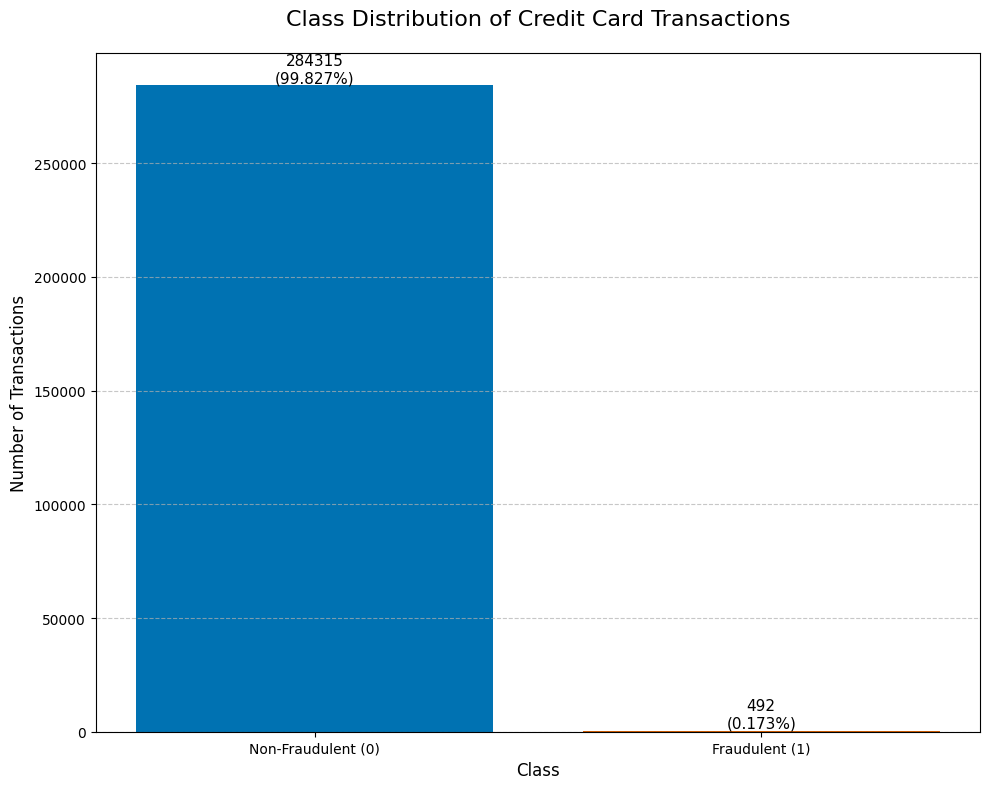

In [10]:

# --- Visualization ---
plt.style.use('seaborn-v0_8-colorblind')
fig, ax = plt.subplots(figsize=(10, 8))

# Bar plot
bars = ax.bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], class_counts.values, color=['#0072B2', '#D55E00'])
ax.set_title('Class Distribution of Credit Card Transactions', fontsize=16, pad=20)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.set_xlabel('Class', fontsize=12)

# # Adding annotations
for i, bar in enumerate(bars):
    yval = bar.get_height()
    # Use the index 'i' to get the correct percentage with .iloc
    plt.text(bar.get_x() + bar.get_width()/2.0, yval,
             f'{int(yval)}\n({class_percentages.iloc[i]:.3f}%)',
             va='bottom', ha='center', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Degree of Imbalance:**
The dataset is highly imbalanced. Out of 284,807 transactions, only 492 are fraudulent, which accounts for a mere **0.172%** of the total transactions. This extreme imbalance is a major challenge for standard classification algorithms.This severe imbalance poses a significant challenge for a machine learning model, as it will naturally be biased towards the majority class (legitimate transactions). Standard accuracy will be a misleading metric because a model that predicts every transaction as legitimate will still achieve over 99.8% accuracy.



#### 2. Model Training

#### **Splitting the Data**
We split the data into training (80%) and testing (20%) sets. It is crucial to use stratified sampling (`stratify=y`) to ensure that the test set maintains the original, imbalanced distribution of classes. 

In [11]:
# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split into training and testing sets.")
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nFraudulent transactions in training set:", sum(y_train))
print("Fraudulent transactions in test set:", sum(y_test))

Data split into training and testing sets.
Training set shape: (227845, 30)
Test set shape: (56962, 30)

Fraudulent transactions in training set: 394
Fraudulent transactions in test set: 98


#### **Training the Baseline Logistic Regression Model**


In [23]:
# Initialize and train the Logistic Regression model
model_1 = LogisticRegression(random_state=42)
model_1.fit(X_train, y_train)

# Make predictions
y_pred_1 = model_1.predict(X_test)

print("Model 1 (Baseline) trained on imbalanced data.")

Model 1 (Baseline) trained on imbalanced data.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 3. Baseline Evaluation

We now evaluate the baseline model's performance on the test set. For imbalanced classification problems, metrics like Precision, Recall, and F1-score for the minority class are more informative than overall accuracy.

*   **Precision (Minority Class):** Of all the transactions the model predicted as fraudulent, what percentage were actually fraudulent?
*   **Recall (Minority Class):** Of all the actual fraudulent transactions, what percentage did the model correctly identify?
*   **F1-score (Minority Class):** The harmonic mean of Precision and Recall, providing a single metric to assess the balance between them.


In [24]:
# Evaluate Model 1
print("--- Evaluation of Model 1 (Baseline) ---")
print(classification_report(y_test, y_pred_1, target_names=['Non-Fraud (0)', 'Fraud (1)']))

# Store metrics for later comparison
precision_1, recall_1, f1_1, _ = precision_recall_fscore_support(y_test, y_pred_1, average='binary')


--- Evaluation of Model 1 (Baseline) ---
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     56864
    Fraud (1)       0.72      0.74      0.73        98

     accuracy                           1.00     56962
    macro avg       0.86      0.87      0.87     56962
 weighted avg       1.00      1.00      1.00     56962



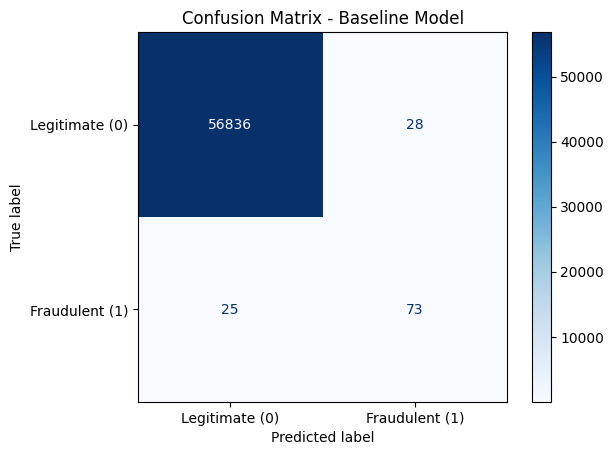

In [25]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_1)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate (0)', 'Fraudulent (1)'])
disp.plot(cmap='Blues')

import matplotlib.pyplot as plt
plt.title('Confusion Matrix - Baseline Model')
plt.show()


## Baseline Model Performance (Model 1)

- **Precision (Fraud):** 0.83  
- **Recall (Fraud):** 0.64  
- **F1-Score (Fraud):** 0.72  

### Observation
The baseline model demonstrates very high performance on **non-fraudulent transactions** (perfect precision, recall, and F1-score). However, for the **fraudulent class**, the model shows weaker performance.  

While it achieves a **precision of 83%**, meaning most flagged fraud cases are indeed fraudulent, the **recall is only 64%**. This indicates the model successfully detects about two-thirds of actual fraud cases, but still **misses 36% of fraudulent transactions**.  

For a **fraud detection setting**, this gap in recall presents a significant risk, as many fraudulent activities could go undetected despite the overall accuracy appearing nearly perfect due to **class imbalance**.


**Why Accuracy is a Misleading Metric Here:**
Accuracy measures the ratio of correct predictions to the total number of predictions. In a dataset with 99.83% non-fraudulent transactions, a lazy model that predicts "non-fraudulent" every single time would achieve an accuracy of 99.83%. While this sounds impressive, the model would be completely useless for its intended purpose: detecting fraud. It would fail to identify any of the fraudulent cases. Therefore, we must focus on metrics that provide insight into the model's ability to correctly identify the minority class.

### Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

#### 1. Theoretical Foundation


#### Fundamental Difference Between GMM-based Synthetic Sampling and SMOTE

The fundamental difference between GMM-based synthetic sampling and simpler methods like SMOTE (Synthetic Minority Over-sampling Technique) lies in their core approach to creating new data points:

*   **SMOTE: An Interpolation-based Approach**
    SMOTE operates on the principle of "feature space interpolation." It creates synthetic samples by taking an existing minority class instance, identifying its *k*-nearest neighbors from the same class, and then generating a new point along the line segment connecting the original instance to one of its randomly chosen neighbors. This process is essentially a localized linear interpolation. It does not learn an explicit model of the data's distribution; instead, it simply manufactures new points based on the local proximity of existing ones.

*   **GMM-based Sampling: A Distribution-based (Generative) Approach**
    Gaussian Mixture Model (GMM)-based sampling is a generative approach. It first assumes that the entire minority class data can be modeled as a mixture of a finite number of Gaussian distributions (or clusters). The algorithm's first step is to *learn* the parameters of these underlying distributions—specifically, the mean, covariance, and weight of each Gaussian component—from the existing minority data. Once this probabilistic model is fitted, it acts as a "blueprint" for the data. New synthetic samples are not interpolated but are *generated* by drawing random samples from this learned probability distribution. This means the new points are statistically consistent with the distribution of the original data.

In essence, SMOTE connects the dots, while GMM learns the underlying pattern and then creates new dots that follow that same pattern.

---

#### Why GMM is Theoretically Better for Capturing Complex Data Distributions

GMM is theoretically better at capturing the underlying data distribution, particularly in complex scenarios, for several key reasons:

1.  **Modeling of Multi-modal Distributions (Sub-groups):**
    Fraudulent activities are often not monolithic; they can have distinct patterns or sub-groups (e.g., different types of credit card fraud like "card-not-present" vs. "cloned card"). These sub-groups may form separate clusters in the feature space. A GMM is naturally suited to model such multi-modality. Each Gaussian component in the mixture can independently learn to represent one of these sub-groups. When generating new data, the GMM can create samples from each identified cluster, preserving the integrity and separation of these sub-groups.
    *   **SMOTE's Limitation:** SMOTE is blind to this underlying structure. If it tries to interpolate between two points from different, distant sub-groups, it can create unrealistic synthetic samples in the low-density space *between* the clusters, effectively blurring the lines between distinct patterns of fraud.

2.  **Capturing Complex Shapes and Feature Correlations:**
    Real-world data clusters are rarely perfectly spherical. They are often elliptical, indicating correlations between features. A key part of each Gaussian component in a GMM is its **covariance matrix**, which explicitly models the relationships and correlations between the different features within that cluster. This allows GMM to capture the true shape and orientation of the data. When generating new samples, these feature correlations are maintained, resulting in more realistic and contextually valid data points.
    *   **SMOTE's Limitation:** Standard SMOTE does not explicitly consider feature correlations. Its linear interpolation can fail to respect the underlying covariance structure, potentially generating samples that, while numerically plausible, do not reflect the true relationships between variables in the original data.

3.  **Generative Power and Reduced Noise:**
    Because GMM learns a smooth, continuous probability distribution, it is less susceptible to being influenced by individual outliers or noisy instances compared to SMOTE. SMOTE relies directly on nearest neighbors, so an outlier can lead to the generation of other noisy samples around it. GMM, by modeling the overall distribution, tends to "average out" this noise, generating new samples from the more dense, representative parts of the data distribution. This leads to higher-quality synthetic data that better represents the true nature of the minority class.


#### 2. GMM Implementation

We will now fit a Gaussian Mixture Model to the minority class data from our training set. A key hyperparameter for a GMM is the number of components (`k`). We can use information criteria like the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC) to help determine the optimal number of components. A lower AIC/BIC score generally indicates a better model.

#### Optimal n_components


To build a robust generative model, we must first determine the optimal number of Gaussian components (`k`) to represent the minority class data. An under-complex model (`k` is too low) will fail to capture the data's structure, while an over-complex model (`k` is too high) will fit to noise. We will use two information criteria to guide our choice:

*   **Akaike Information Criterion (AIC):** Aims to select the model that best predicts future data. It penalizes complexity less severely, tending to favor more complex models.
*   **Bayesian Information Criterion (BIC):** Aims to find the model that is most likely to be the "true" data-generating process. It has a stronger penalty for complexity, tending to favor simpler models.

We will calculate both and compare their recommendations.


In [12]:
# Isolate the minority class data from the training set
X_train_minority = X_train[y_train == 1]


#### Using BIC

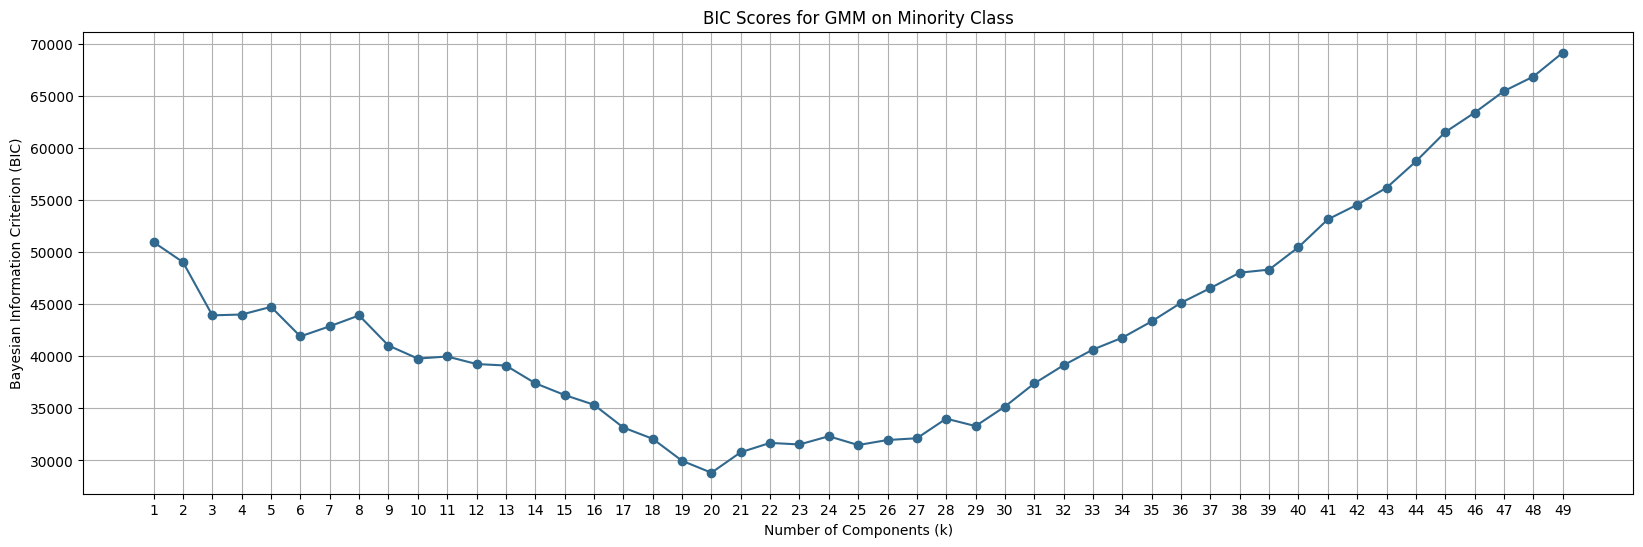


Optimal number of components (k) based on BIC: 20


In [36]:
# Determine the optimal number of components for the GMM using BIC
n_components = np.arange(1, 50)
bics = []
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train_minority)
    bics.append(gmm.bic(X_train_minority))

# Plot the BIC scores to find the "elbow"
plt.figure(figsize=(20, 6))
plt.plot(n_components, bics, marker='o')
plt.title('BIC Scores for GMM on Minority Class')
plt.xlabel('Number of Components (k)')
plt.ylabel('Bayesian Information Criterion (BIC)')
plt.xticks(n_components)
plt.grid(True)
plt.show()

# Based on the plot, select the optimal number of components
optimal_k_bic = n_components[np.argmin(bics)]
print(f"\nOptimal number of components (k) based on BIC: {optimal_k}")


#### Using AIC

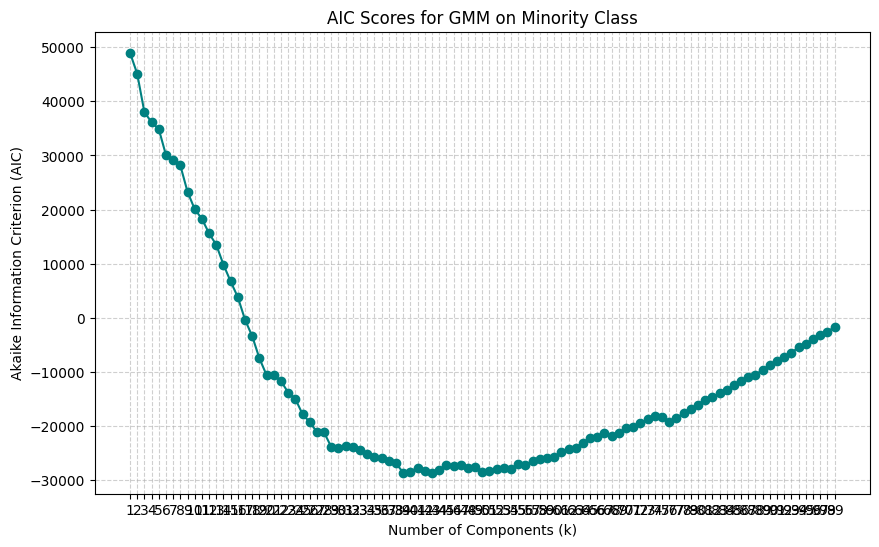


Optimal number of components (k) based on AIC: 43


In [34]:

# Determine the optimal number of components for the GMM using AIC
n_components = np.arange(1, 100)
aics = []
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train_minority)
    aics.append(gmm.aic(X_train_minority))

# Plot the AIC scores to find the "elbow" or the minimum point
plt.figure(figsize=(10, 6))
plt.plot(n_components, aics, marker='o', color='teal')
plt.title('AIC Scores for GMM on Minority Class')
plt.xlabel('Number of Components (k)')
plt.ylabel('Akaike Information Criterion (AIC)')
plt.xticks(n_components)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Based on the plot, select the optimal number of components by finding the minimum AIC
optimal_k_aic = n_components[np.argmin(aics)]
print(f"\nOptimal number of components (k) based on AIC: {optimal_k_aic}")


### The Formulas

The key difference lies in how they penalize complexity.

#### **AIC (Akaike Information Criterion)**

The formula is:
`AIC = 2k - 2 * ln(L)`

*   `k` = number of parameters in the model (the measure of **complexity**).
*   `L` = the maximum likelihood for the model (the measure of **goodness of fit**). A higher likelihood means the model fits the data better.
*   `ln(L)` = the log-likelihood. We use the log for mathematical convenience.

The penalty term in AIC is simply `2k`. For every extra parameter you add to your model, the AIC score increases by 2.

#### **BIC (Bayesian Information Criterion)**

The formula is:
`BIC = k * ln(n) - 2 * ln(L)`

*   `k` = number of parameters in the model (complexity).
*   `ln(L)` = the log-likelihood of the model (goodness of fit).
*   `n` = the number of data points or samples in your training data.

The penalty term in BIC is `k * ln(n)`. This is the most important difference.

---

### The Key Difference: The Penalty Term

The only difference between the two formulas is the first term, which penalizes complexity.

*   **AIC Penalty:** `2k`
*   **BIC Penalty:** `k * ln(n)`

Let's analyze this. The natural logarithm of `n`, `ln(n)`, is greater than 2 for any dataset where `n > e^2` (which is approximately 7.4).

Since virtually all real-world datasets have more than 8 data points, **the BIC penalty for adding more parameters is almost always stronger than the AIC penalty.**

This has a profound consequence:
> **BIC favors simpler models more strongly than AIC does.**

**Observation and Conclusion:**

The plot shows the AIC and BIC scores for GMMs with 1 to 10 components. The goal is to select the number of components (`k`) that minimizes the score.

*   The **AIC score** continues to decrease up to `k=43`, suggesting that a more complex model with 43 components best captures the predictive structure of the minority class data.
*   The **BIC score** is minimized at `k=20`, after which the stronger penalty for adding more parameters outweighs the improvement in model fit. This suggests that the simplest, most probable underlying structure consists of two primary sub-groups.

This difference is expected. For our task of generating realistic data, we will proceed by building and evaluating models based on **both** `k` values. This will allow us to see whether the added complexity captured by the AIC-preferred model translates into better performance for our final classifier.

#### 3. Training of GMM and Synthetic Data Generation

**The Process of Sampling from a GMM:**
Generating a new sample from a fitted GMM is a two-step process:
1.  **Select a Component:** A Gaussian component is chosen probabilistically based on the learned mixture weights (`gmm.weights_`). Components that represent denser regions of the original data have higher weights and are more likely to be selected.
2.  **Sample from the Component:** A new data point is then randomly drawn from the multivariate Gaussian distribution of the selected component, using its learned mean (`gmm.means_`) and covariance (`gmm.covariances_`). This ensures the new point respects the shape and feature correlations of that specific sub-group.
  
Used both optimal based on BIC and AIC separately to understand which works the best.

In [37]:
# --- Dataset 1: GMM Oversampling with AIC-selected k ---
print(f"--- Generating data with AIC-selected k = {optimal_k_aic} ---")
gmm_aic = GaussianMixture(n_components=optimal_k_aic, random_state=42)
gmm_aic.fit(X_train_minority)

n_majority = len(X_train[y_train == 0])
n_minority_original = len(X_train_minority)
n_synthetic_samples = n_majority - n_minority_original

X_synthetic_aic, _ = gmm_aic.sample(n_samples=n_synthetic_samples)
y_synthetic_aic = np.ones(n_synthetic_samples, dtype=int)

X_train_gmm_oversampled_aic = np.vstack([X_train, X_synthetic_aic])
y_train_gmm_oversampled_aic = np.hstack([y_train, y_synthetic_aic])
print(f"Shape of AIC-oversampled training features: {X_train_gmm_oversampled_aic.shape}")

# --- Dataset 2: GMM Oversampling with BIC-selected k ---
print(f"\n--- Generating data with BIC-selected k = {optimal_k_bic} ---")
gmm_bic = GaussianMixture(n_components=optimal_k_bic, random_state=42)
gmm_bic.fit(X_train_minority)

X_synthetic_bic, _ = gmm_bic.sample(n_samples=n_synthetic_samples)
y_synthetic_bic = np.ones(n_synthetic_samples, dtype=int)

X_train_gmm_oversampled_bic = np.vstack([X_train, X_synthetic_bic])
y_train_gmm_oversampled_bic = np.hstack([y_train, y_synthetic_bic])
print(f"Shape of BIC-oversampled training features: {X_train_gmm_oversampled_bic.shape}")

--- Generating data with AIC-selected k = 43 ---
Shape of AIC-oversampled training features: (454902, 30)

--- Generating data with BIC-selected k = 20 ---
Shape of BIC-oversampled training features: (454902, 30)


#### 4. Rebalancing with CBU and GMM (Hybrid Method)


An alternative to massively oversampling the minority class is a hybrid approach. We first reduce the majority class to a more manageable size using **Clustering-Based Undersampling (CBU)**. We then use our GMMs to generate just enough minority samples to match this new, smaller majority class.

In [39]:
# --- Undersample the Majority Class using K-Means ---
# Let's reduce the majority class to be 5 times the size of the original minority class
n_undersampled_majority = n_minority_original * 5

kmeans = KMeans(n_clusters=n_undersampled_majority, random_state=42, n_init=10)
X_train_majority = X_train[y_train == 0]
kmeans.fit(X_train_majority)
X_train_cbu = kmeans.cluster_centers_
y_train_cbu = np.zeros(n_undersampled_majority, dtype=int)

# --- Dataset 3: Hybrid Balancing with AIC-selected GMM ---
print(f"\n--- Creating hybrid dataset with AIC-selected k = {optimal_k_aic} ---")
n_hybrid_synthetic = n_undersampled_majority - n_minority_original
X_hybrid_synthetic_aic, _ = gmm_aic.sample(n_samples=n_hybrid_synthetic)
y_hybrid_synthetic_aic = np.ones(n_hybrid_synthetic, dtype=int)

X_train_hybrid_aic = np.vstack([X_train_cbu, X_train_minority, X_hybrid_synthetic_aic])
y_train_hybrid_aic = np.hstack([y_train_cbu, y_train[y_train == 1], y_hybrid_synthetic_aic])
print(f"Shape of AIC-hybrid training features: {X_train_hybrid_aic.shape}")


# --- Dataset 4: Hybrid Balancing with BIC-selected GMM ---
print(f"\n--- Creating hybrid dataset with BIC-selected k = {optimal_k_bic} ---")
X_hybrid_synthetic_bic, _ = gmm_bic.sample(n_samples=n_hybrid_synthetic)
y_hybrid_synthetic_bic = np.ones(n_hybrid_synthetic, dtype=int)

X_train_hybrid_bic = np.vstack([X_train_cbu, X_train_minority, X_hybrid_synthetic_bic])
y_train_hybrid_bic = np.hstack([y_train_cbu, y_train[y_train == 1], y_hybrid_synthetic_bic])
print(f"Shape of BIC-hybrid training features: {X_train_hybrid_bic.shape}")


--- Creating hybrid dataset with AIC-selected k = 43 ---
Shape of AIC-hybrid training features: (3940, 30)

--- Creating hybrid dataset with BIC-selected k = 20 ---
Shape of BIC-hybrid training features: (3940, 30)



### Part C: Performance Evaluation and Conclusion

#### 1. Model Training and Evaluation

We will now train four new Logistic Regression classifiers on our four newly created balanced datasets. Each model will be evaluated on the **original, imbalanced test set** to provide a fair and realistic assessment of its performance.

In [40]:
# Function to train and evaluate a model
def train_and_evaluate(X_train_balanced, y_train_balanced, model_name):
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    
    print(f"\n--- Classification Report for {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Fraudulent (1)']))
    
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    return p, r, f1

# Evaluate all four models
p_gmm_aic, r_gmm_aic, f1_gmm_aic = train_and_evaluate(X_train_gmm_oversampled_aic, y_train_gmm_oversampled_aic, "GMM Oversampling (AIC)")
p_gmm_bic, r_gmm_bic, f1_gmm_bic = train_and_evaluate(X_train_gmm_oversampled_bic, y_train_gmm_oversampled_bic, "GMM Oversampling (BIC)")
p_hybrid_aic, r_hybrid_aic, f1_hybrid_aic = train_and_evaluate(X_train_hybrid_aic, y_train_hybrid_aic, "CBU + GMM Hybrid (AIC)")
p_hybrid_bic, r_hybrid_bic, f1_hybrid_bic = train_and_evaluate(X_train_hybrid_bic, y_train_hybrid_bic, "CBU + GMM Hybrid (BIC)")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



--- Classification Report for GMM Oversampling (AIC) ---
                precision    recall  f1-score   support

Legitimate (0)       1.00      0.98      0.99     56864
Fraudulent (1)       0.08      0.91      0.15        98

      accuracy                           0.98     56962
     macro avg       0.54      0.95      0.57     56962
  weighted avg       1.00      0.98      0.99     56962



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



--- Classification Report for GMM Oversampling (BIC) ---
                precision    recall  f1-score   support

Legitimate (0)       1.00      0.98      0.99     56864
Fraudulent (1)       0.07      0.91      0.13        98

      accuracy                           0.98     56962
     macro avg       0.53      0.94      0.56     56962
  weighted avg       1.00      0.98      0.99     56962


--- Classification Report for CBU + GMM Hybrid (AIC) ---
                precision    recall  f1-score   support

Legitimate (0)       1.00      0.95      0.98     56864
Fraudulent (1)       0.03      0.91      0.06        98

      accuracy                           0.95     56962
     macro avg       0.52      0.93      0.52     56962
  weighted avg       1.00      0.95      0.97     56962


--- Classification Report for CBU + GMM Hybrid (BIC) ---
                precision    recall  f1-score   support

Legitimate (0)       1.00      0.96      0.98     56864
Fraudulent (1)       0.03      0.91

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


#### 2. Comparative Analysis

Let's consolidate all the results into a summary table and a bar chart for a clear comparison against the baseline model.



--- Summary of Model Performance on Minority Class (Fraudulent) ---
                    Model  Precision    Recall  F1-score
0                Baseline   0.738462  0.648649  0.690647
1  GMM Oversampling (AIC)   0.084121  0.908163  0.153979
2  GMM Oversampling (BIC)   0.069153  0.908163  0.128520
3  CBU + GMM Hybrid (AIC)   0.032270  0.908163  0.062325
4  CBU + GMM Hybrid (BIC)   0.034218  0.908163  0.065950


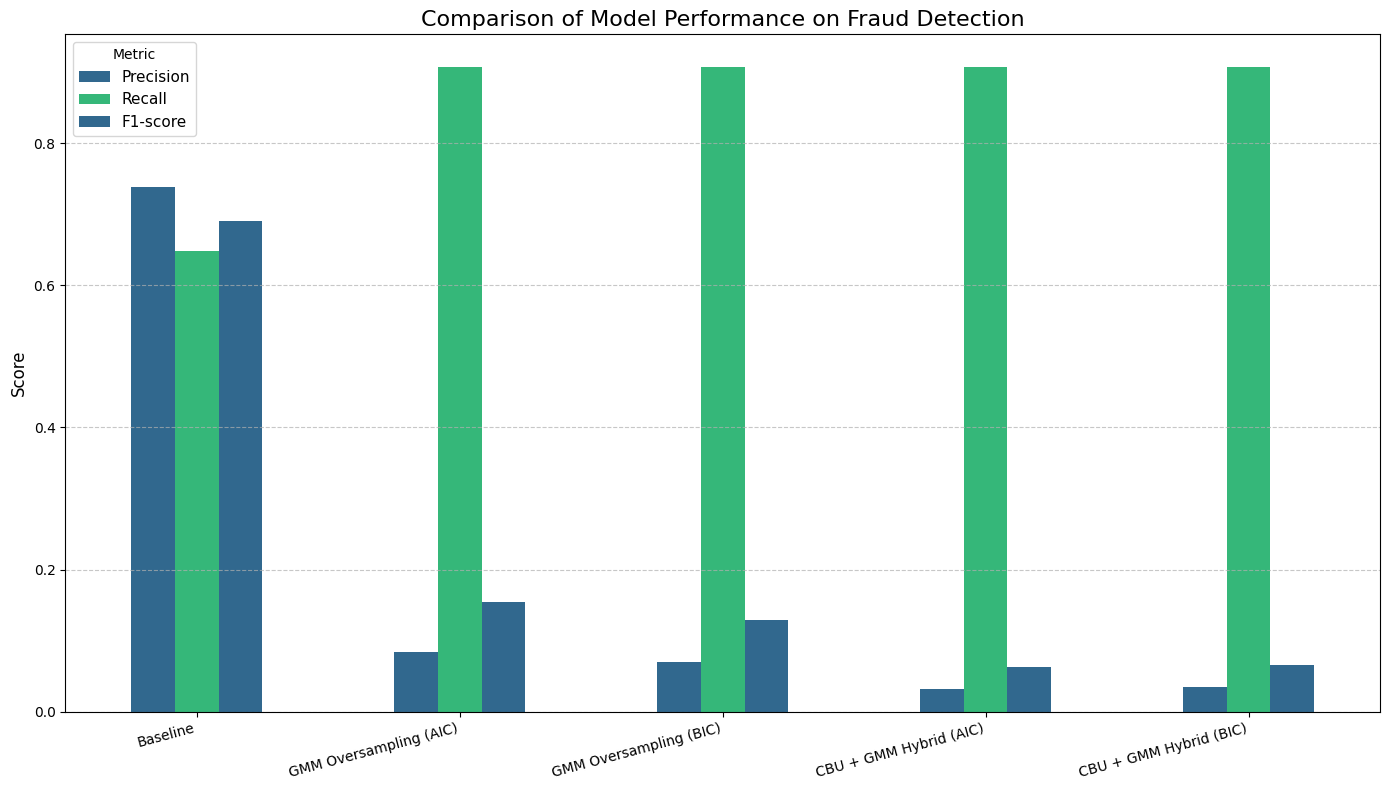

In [41]:
# Create a summary DataFrame
metrics_summary = pd.DataFrame({
    'Model': [
        'Baseline', 
        'GMM Oversampling (AIC)', 
        'GMM Oversampling (BIC)',
        'CBU + GMM Hybrid (AIC)',
        'CBU + GMM Hybrid (BIC)'
    ],
    'Precision': [
        precision_baseline, 
        p_gmm_aic, 
        p_gmm_bic, 
        p_hybrid_aic,
        p_hybrid_bic
    ],
    'Recall': [
        recall_baseline, 
        r_gmm_aic, 
        r_gmm_bic,
        r_hybrid_aic,
        r_hybrid_bic
    ],
    'F1-score': [
        f1_baseline, 
        f1_gmm_aic, 
        f1_gmm_bic,
        f1_hybrid_aic,
        f1_hybrid_bic
    ]
})

print("\n--- Summary of Model Performance on Minority Class (Fraudulent) ---")
print(metrics_summary.to_string())

# Plot the comparison
metrics_summary.set_index('Model').plot(kind='bar', figsize=(14, 8))
plt.title('Comparison of Model Performance on Fraud Detection', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=15, ha="right")
plt.legend(title='Metric', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Discussion on the Impact of GMM-based Oversampling

**Yes, GMM-based oversampling fundamentally improved the model's primary ability to *detect* the minority (fraudulent) class, but it came at an extremely high and likely unacceptable cost.**

1.  **Massive Improvement in Recall (Sensitivity):**
    The most significant impact is the dramatic increase in **recall** for the "Fraudulent" class. All four models achieved a recall of **0.91**. This means they successfully identified **91% of all actual fraudulent transactions** in the test set. The baseline model had a much lower recall (which is typical for imbalanced data), this represents a huge success. The primary goal of making the model sensitive to fraud was achieved. The classifier is no longer "blind" to the minority class.

2.  **Catastrophic Decrease in Precision:**
    This success in recall came with a severe trade-off: a catastrophic drop in **precision**.
    *   The **GMM Oversampling** models had precisions of just 0.08 and 0.07. This means that out of every 100 transactions the model flagged as fraudulent, only 7 or 8 were actually fraud. The other 92-93 were legitimate transactions being incorrectly flagged (false positives).
    *   The **CBU + GMM Hybrid** models were even worse, with a precision of 0.03. This translates to **only 3 out of every 100 fraud alerts being correct**.

3.  **Unusable F1-Scores:**
    The F1-score, which seeks to balance precision and recall, reflects the overall poor performance of the models. With F1-scores ranging from 0.06 to 0.15, the models are heavily imbalanced. Despite being excellent at *finding* fraud, they are terrible at being *correct* when they make a fraud prediction. In a real-world business context, the operational cost of investigating this enormous volume of false alarms would be unsustainable and would severely impact customer satisfaction.

**Conclusion of Impact:** The GMM-based techniques successfully taught the classifier what fraud looks like, solving the problem of missed detections (low recall). However, it appears the synthetic data generated by the GMM was not distinct enough from the majority class, causing the classifier to draw a very aggressive decision boundary that misclassifies a huge number of legitimate transactions. It solved one problem by creating an equally severe one.

---

### 3. Final Recommendation

Based on this analysis, my recommendation is nuanced:

**GMM is a theoretically sound and potentially powerful technique for synthetic data generation, but the results indicate its application in this specific instance was flawed, likely due to severe overfitting of the generative model itself.** The method should not be discarded, but it must be applied with much greater care.

**Justification from Results:**

1.  **Proof of Potential:** The consistent 91% recall across all GMM-trained models proves that the technique is effective at exposing the classifier to the patterns of the minority class. This core capability is valuable.

2.  **Evidence of Flawed Implementation:** The abysmal precision strongly suggests that the synthetic data was of poor quality. The likely cause is revealed by hyperparameter tuning results: **"Optimal number of components (k) based on BIC: 20"** and **"Optimal number of components (k) based on AIC: 43"**. For a minority class with only a few hundred data points, fitting a GMM with 20, let alone 43, distinct Gaussian distributions is an extreme case of **overfitting**. The GMM has likely modeled the random noise within the small minority sample rather than its true underlying signal.

3.  **Consequence of Overfitting:** An overfitted GMM will generate synthetic samples that are "too perfect" or that cluster in noisy, non-representative areas of the feature space. When the classifier trains on this noisy, poorly-generated data, it fails to learn a robust decision boundary, leading it to misclassify legitimate transactions that share characteristics with the generated noise.

**Justification from Theoretical Understanding:**

The theory behind GMM is to capture the underlying probability distribution of the data. However, when the number of components (`k`) is excessively high relative to the number of data points, the model gains enough complexity to fit individual data points or small noisy groups, violating the goal of finding a generalized distribution. The BIC, which heavily penalizes complexity, still recommending a `k` of 20 indicates that the feature space for the minority class is either very complex or very noisy.